<a href="https://colab.research.google.com/github/JeffreyAsuncion/LambdaUnit2Project/blob/master/Flight_Status_Predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Flight Status Predictor
=======
Unit 2 Build Project

##Wouldn't it be great to predict your FLIGHT STATUS before Booking your next Vacation?



Summary
==========

I did some research and found a flight data for over 2,000,000 domestic US.flights for 2019 and 2020. After completing Exploratory Data Analysis(EDA) and predictive modeling, I have found that the main problem that you run into as data leakage. Another issue was the size of the class that I am trying to predict. The class is present 20/80 in the dataset; therefore we have an imbalanced dataset. 
From our model we found, couple factors that will help us to predict the FLIGHT STATUS before a booking your next flight. What this means is that with our model we could predict if we will be ON-TIME or DELAYED with 64.5% accuracy. With this knowledge we can plan our next vacation with less headache and no longer fear being stuck in the airport.



About this Data Sets
======

This data is collected from the Bureau of Transportation Statistics, Govt. of the USA. This data is open-sourced under U.S. Govt. Works. This dataset contains all the flights in the month of January & February 2019 and January & February 2020. There are more than 1,000,000 flights in the months of January & February throughout the United States. The features were manually chosen to do a primary time series analysis. There are several other features available on their website.

This data could well be used to predict the flight delay at the destination airport specifically for the month of January & February in upcoming years as the data is for January & February only.

Data Exploration
======

In [ ]:
#NOTE this notebook takes about 30 mins to run
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*
    !pip install eli5
    !pip install pdpbox
# If you're working locally:
else:
    DATA_PATH = '../data/'

In [ ]:
# import libraries
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport
from sklearn.model_selection import train_test_split

%matplotlib inline
import matplotlib.pyplot as plt
import graphviz
from sklearn.tree import export_graphviz
import seaborn as sns

from sklearn.pipeline import make_pipeline
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import eli5
from eli5.sklearn import PermutationImportance

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from pdpbox import pdp

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of th

In [ ]:
# import data from kaggle
!wget https://raw.githubusercontent.com/JeffreyAsuncion/dataset2020a/master/kaggle.json
!mkdir ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d divyansh22/flight-delay-prediction
!kaggle datasets download -d divyansh22/february-flight-delay-prediction
!unzip /content/flight-delay-prediction.zip
!unzip /content/february-flight-delay-prediction.zip

#Original dataset found here
url_jan_2019_2020 = 'https://www.kaggle.com/divyansh22/flight-delay-prediction/download'
url_feb_2019_2020 = 'https://www.kaggle.com/divyansh22/february-flight-delay-prediction/download'

--2020-06-24 16:16:02--  https://raw.githubusercontent.com/JeffreyAsuncion/dataset2020a/master/kaggle.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 71 [text/plain]
Saving to: ‘kaggle.json’

kaggle.json         100%[===================>]      71  --.-KB/s    in 0s      

2020-06-24 16:16:02 (3.35 MB/s) - ‘kaggle.json’ saved [71/71]

 39% 9.00M/22.9M [00:00<00:00, 20.1MB/s]
100% 22.9M/22.9M [00:00<00:00, 46.6MB/s]
 42% 9.00M/21.3M [00:00<00:00, 72.8MB/s]
100% 21.3M/21.3M [00:00<00:00, 104MB/s] 
Archive:  /content/flight-delay-prediction.zip
  inflating: Jan_2019_ontime.csv     
  inflating: Jan_2020_ontime.csv     
Archive:  /content/february-flight-delay-prediction.zip
  inflating: Feb_2019_ontime.csv     
  inflating: Feb_2020_ontime.csv     


In [ ]:
# Time Series Split

# Concat train.csv & Jan&Feb 2019
train1 = pd.read_csv('Jan_2019_ontime.csv')
train2 = pd.read_csv('Feb_2019_ontime.csv')
# Validate on Feb_2020
val = pd.read_csv('Jan_2020_ontime.csv')
# Test on Feb_2020
test = pd.read_csv('Feb_2020_ontime.csv')

In [ ]:
# Engineer new feature a month column
# to map the data from JAN and FEB
def AddMonthJan(X):
    X['MONTH_OF_YEAR'] = 'JAN'
    return X
def AddMonthFeb(X):
    X['MONTH_OF_YEAR'] = 'FEB'
    return X

train1 = AddMonthJan(train1)
train2 = AddMonthFeb(train2)
val = AddMonthJan(val)
test = AddMonthFeb(test)

In [ ]:
target='DEP_DEL15'
# combine JAN 2019 & FEB 2019 to make out Training Dataset
train = pd.concat([train1,train2], axis=0)

train_DL = train.copy()

print('NOTE: This notebook takes about 30 mins to run')
print('='*50)
print('train data set : ', train.shape)
print('val data set : ', val.shape)
print('test data set  : ', test.shape)

NOTE: This notebook takes about 30 mins to run
train data set :  (1117160, 23)
val data set :  (607346, 23)
test data set  :  (574268, 23)


Exploratory Data Analysis
====


In [ ]:
profile = ProfileReport(train, minimal=True)

profile.to_notebook_iframe()

# Save Profile report to HTML file - thank you Bruno Janota
profile.to_file(output_file='jan2019_flight_pred_profile_report_minimal.html')

In [ ]:
train.head().T

,0,1,2,3,4
DAY_OF_MONTH,1,1,1,1,1
DAY_OF_WEEK,2,2,2,2,2
OP_UNIQUE_CARRIER,9E,9E,9E,9E,9E
OP_CARRIER_AIRLINE_ID,20363,20363,20363,20363,20363
OP_CARRIER,9E,9E,9E,9E,9E
TAIL_NUM,N8688C,N348PQ,N8896A,N8886A,N8974C
OP_CARRIER_FL_NUM,3280,3281,3282,3283,3284
ORIGIN_AIRPORT_ID,11953,13487,11433,15249,10397
ORIGIN_AIRPORT_SEQ_ID,1195302,1348702,1143302,1524906,1039707
ORIGIN,GNV,MSP,DTW,TLH,ATL


Subset Dataset for Quick Testing
=======


In [ ]:
# ## to run faster
# TIMES = 1000
# train = train.sample(8*TIMES, random_state=42)
# val = val.sample(4*TIMES, random_state=42)
# test = test.sample(4*TIMES, random_state=42)

# print('train data set : ', train.shape)
# print('val data set : ', val.shape)
# print('test data set  : ', test.shape)

Engineer Features - Wrangle
======


In [ ]:
# These Feature are Future data - AKA Data Leakage
# Data Leakage - Experiment at the end of the notebook
train[['ARR_DEL15', 'ARR_TIME',
      'CANCELLED', 'DIVERTED','DEP_TIME']].head()

,ARR_DEL15,ARR_TIME,CANCELLED,DIVERTED,DEP_TIME
0,0.0,722.0,0.0,0.0,601.0
1,0.0,1633.0,0.0,0.0,1359.0
2,0.0,1329.0,0.0,0.0,1215.0
3,0.0,1625.0,0.0,0.0,1521.0
4,0.0,1940.0,0.0,0.0,1847.0


In [ ]:
def DataLeakage(X):
    X = X.copy()

    # Map target column 
    X['DEP_DEL15'] = X['DEP_DEL15'].replace({0 : 'ON-TIME',
                                             1 : 'DELAYED'})
    
    # Split the Departure Time Block to the start of the time window
    X['DEP_TIME_BLK']  = X['DEP_TIME_BLK'].str.split('-', expand=True)
    X['DEP_TIME_BLK'] = pd.to_numeric(X['DEP_TIME_BLK'] )
    
    # Drop ['Unnamed: 21'] is all NaNs and corrupted data
    X = X.drop(columns='Unnamed: 21', axis=1)

    # Comment this out to Cause a Data Leakage Experiment 
    # Drop to prevent data leakage from future data
    # data_leakage = ['ARR_DEL15', 'ARR_TIME',
    #                 'CANCELLED', 'DIVERTED','DEP_TIME']
    # X = X.drop(columns=data_leakage, axis=1)
    
    # Drop duplicates 
    dups = [ 'OP_CARRIER','ORIGIN_AIRPORT_SEQ_ID','DEST_AIRPORT_SEQ_ID',
            'OP_UNIQUE_CARRIER','ORIGIN', 'DEST','OP_CARRIER_FL_NUM']
    X = X.drop(columns=dups, axis=1)

    # This cleans up the rows with the Nans
    X.dropna(subset=['DEP_DEL15'], inplace=True)
    
    return X

train_DL = DataLeakage(train_DL)
val_DL = DataLeakage(val)
test_DL = DataLeakage(test)

In [ ]:
def wrangle(X):
    X = X.copy()

    # Map target column 
    X['DEP_DEL15'] = X['DEP_DEL15'].replace({0 : 'ON-TIME',
                                             1 : 'DELAYED'})
    
    # Split the Departure Time Block to the start of the time window
    X['DEP_TIME_BLK']  = X['DEP_TIME_BLK'].str.split('-', expand=True)
    X['DEP_TIME_BLK'] = pd.to_numeric(X['DEP_TIME_BLK'] )
    
    # Drop ['Unnamed: 21'] is all NaNs and corrupted data
    X = X.drop(columns='Unnamed: 21', axis=1)

    # Comment this out to Cause a Data Leakage Experiment 
    # Drop to prevent data leakage from future data
    data_leakage = ['ARR_DEL15', 'ARR_TIME',
                    'CANCELLED', 'DIVERTED','DEP_TIME']
    X = X.drop(columns=data_leakage, axis=1)
    
    # Drop duplicates 
    dups = [ 'OP_CARRIER','ORIGIN_AIRPORT_SEQ_ID','DEST_AIRPORT_SEQ_ID',
            'OP_UNIQUE_CARRIER','ORIGIN', 'DEST','OP_CARRIER_FL_NUM']
    X = X.drop(columns=dups, axis=1)

    # This cleans up the rows with the Nans
    X.dropna(subset=['DEP_DEL15'], inplace=True)
    
    return X

train = wrangle(train)
val = wrangle(val)
test = wrangle(test)


Under Sample the Majority Class
============


In [ ]:
def UnderSample(X):
    '''
    This is function undersamples Majority Class
    1 to 1 if RATIO == 1
    '''
    RATIO=1
    delayed_UnderSample = X[X[target]=='DELAYED']
    delayed_UnderSample.shape[0]

    on_time_UnderSample = X[X[target]=='ON-TIME'].sample(delayed_UnderSample.shape[0]*RATIO,
                                                         random_state=42)
    on_time_UnderSample.shape

    X_UnderSample  = pd.concat([delayed_UnderSample,
                               on_time_UnderSample],
                               axis=0)
    return X_UnderSample

# Note that Under Sampling ONLY is performed on the training data
train_UndSamp = UnderSample(train)

In [ ]:
train.describe(exclude='number')

,TAIL_NUM,DEP_DEL15,MONTH_OF_YEAR
count,1085978,1085978,1085978
unique,5594,2,2
top,N488HA,ON-TIME,JAN
freq,654,875653,567630


In [ ]:
train.describe()

,DAY_OF_MONTH,DAY_OF_WEEK,OP_CARRIER_AIRLINE_ID,ORIGIN_AIRPORT_ID,DEST_AIRPORT_ID,DEP_TIME_BLK,DISTANCE
count,1.085978e+06,1.085978e+06,1.085978e+06,1.085978e+06,1.085978e+06,1.085978e+06,1.085978e+06
mean,1.526234e+01,3.874580e+00,1.998324e+04,1.265542e+04,1.265554e+04,1.286540e+03,8.021401e+02
std,8.569508e+00,1.949039e+00,3.753106e+02,1.520324e+03,1.520568e+03,5.070966e+02,5.912951e+02
min,1.000000e+00,1.000000e+00,1.939300e+04,1.013500e+04,1.013500e+04,1.000000e+00,3.100000e+01
25%,8.000000e+00,2.000000e+00,1.979000e+04,1.129200e+04,1.129200e+04,9.000000e+02,3.660000e+02
50%,1.500000e+01,4.000000e+00,1.997700e+04,1.288900e+04,1.288900e+04,1.300000e+03,6.420000e+02
75%,2.300000e+01,5.000000e+00,2.036800e+04,1.402500e+04,1.402700e+04,1.700000e+03,1.045000e+03
max,3.100000e+01,7.000000e+00,2.045200e+04,1.621800e+04,1.621800e+04,2.300000e+03,4.983000e+03


Begin with baselines for classification.
=====

This is a multi-class classification problem. The majority class occurs with 80.6% frequency ON-TIME.

ON-TIME    0.806327
DELAYED    0.193673
Name: DEP_DEL15, dtype: float64
ON-TIME
0.8063266475011465


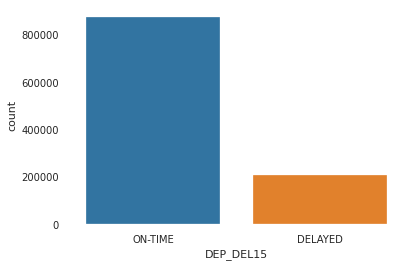

In [ ]:
print(train[target].value_counts(normalize=True))
y_train = train[target]
majority_class = y_train.mode()[0] #what is the mode - the most common in column[0] 
print(majority_class)
y_pred = [majority_class]  * len(y_train) # assume 
baseline_accuracy_score = accuracy_score(y_train, y_pred)
print(baseline_accuracy_score)
sns.countplot(train[target]);

Select Features to use in Model
========


In [ ]:
# This section deals with the high cardinality

# The status_group column is the target
target='DEP_DEL15'

# Get a dataframe with all train columns except the target
train_features = train.drop(columns=[target])

# Get a list of the numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

# Get a series with the cardinality of the nonnumeric features
cardinality = train_features.select_dtypes(exclude='number').nunique()

# Get a list of all categorical features with cardinality 
#<= 5550 == the number of different airplanes
categorical_features = cardinality[cardinality <= 5600].index.tolist()

# Combine the lists 
features = numeric_features + categorical_features
print(features)
print(len(features))

#Arrange data into X features matrix and y target vector
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

X_train_UndSamp = train_UndSamp[features]
y_train_UndSamp = train_UndSamp[target]

['DAY_OF_MONTH', 'DAY_OF_WEEK', 'OP_CARRIER_AIRLINE_ID', 'ORIGIN_AIRPORT_ID', 'DEST_AIRPORT_ID', 'DEP_TIME_BLK', 'DISTANCE', 'TAIL_NUM', 'MONTH_OF_YEAR']
9


Logistic  Regression
========


Validation Accuracy :  0.8636736718904781
ROC AUC SCORE(VAL) : 0.5729004211207961
              precision    recall  f1-score   support

     DELAYED       0.00      0.00      0.00     81884
     ON-TIME       0.86      1.00      0.93    518763

    accuracy                           0.86    600647
   macro avg       0.43      0.50      0.46    600647
weighted avg       0.75      0.86      0.80    600647



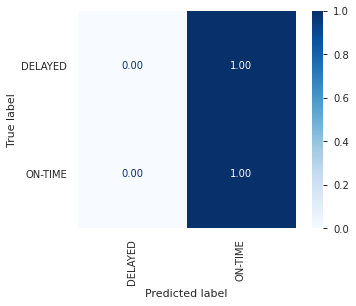

In [ ]:
lr = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    StandardScaler(),
    LogisticRegression(multi_class='auto', solver='lbfgs', n_jobs=1))

# Fit on train
lr.fit(X_train, y_train)

# Score on validation
lr_accuracy_score_val = lr.score(X_val, y_val)
print(f'Validation Accuracy : ', lr_accuracy_score_val)

y_pred = lr.predict(X_val)

plot_confusion_matrix(lr, X_val, y_val, values_format='.2f',
                      cmap='Blues', xticks_rotation='vertical', normalize='true')

y_pred_proba = lr.predict_proba(X_val)[:, -1]

lr_roc_auc_score = roc_auc_score(y_val, y_pred_proba)
print(f'ROC AUC SCORE(VAL) : {lr_roc_auc_score}')

print(classification_report(y_val, y_pred))

### Try adjusting these hyperparameters

#### Random Forest
- class_weight (for imbalanced classes)
- max_depth (usually high, can try decreasing)
- n_estimators (too low underfits, too high wastes time)
- min_samples_leaf (increase if overfitting)
- max_features (decrease for more diverse trees)


Random Forest Classifier - Model
==========

Validation Accuracy : 0.857
      Test Accuracy : 0.849
 ROC AUC SCORE(val) : 0.591
              precision    recall  f1-score   support

     DELAYED       0.22      0.02      0.03     81884
     ON-TIME       0.86      0.99      0.92    518763

    accuracy                           0.86    600647
   macro avg       0.54      0.50      0.48    600647
weighted avg       0.78      0.86      0.80    600647

CPU times: user 6min 49s, sys: 1.08 s, total: 6min 50s
Wall time: 3min 48s


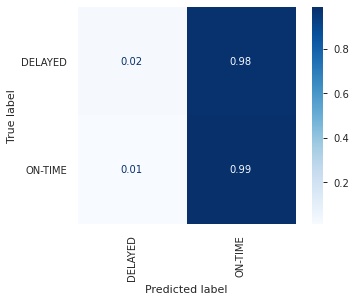

In [ ]:
%%time
# RandomForestClassifier
rfc = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='mean'), 
    RandomForestClassifier(n_estimators=115, random_state=42, max_depth=15, 
                           min_samples_leaf=2, n_jobs=-1))

# Fit on train
rfc.fit(X_train, y_train)

# Score on validation
rfc_accuracy_score_val = rfc.score(X_val, y_val)
print(f'Validation Accuracy : {rfc_accuracy_score_val:.3f}')
rfc_accuracy_score_test = rfc.score(X_test, y_test)
print(f'      Test Accuracy : {rfc_accuracy_score_test:.3f}')

y_pred = rfc.predict(X_val)

plot_confusion_matrix(rfc, X_val, y_val, values_format='.2f',
                      cmap='Blues', xticks_rotation='vertical', normalize='true')

y_pred_proba = rfc.predict_proba(X_val)[:, -1] 

rfc_roc_auc_score = roc_auc_score(y_val, y_pred_proba)
print(f' ROC AUC SCORE(val) : {rfc_roc_auc_score:.3f}')

print(classification_report(y_val, y_pred))

UnderSampling Majority Class
=====


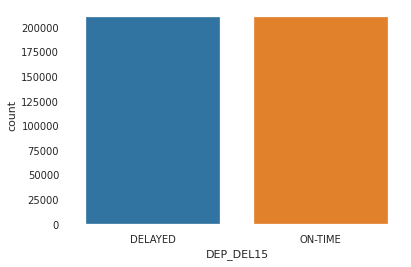

In [ ]:
# Definition of undersampling 
# Majority Class == Minority Class
baseline_accuracy_score_UndSamp = 0.5
sns.countplot(train_UndSamp[target]);

Logistic Regression - with Under Sampling of Majority Class
=======


Validation Accuracy :  0.6208488513219911
ROC AUC SCORE(VAL) : 0.5737418676287136
              precision    recall  f1-score   support

     DELAYED       0.00      0.00      0.00     81884
     ON-TIME       0.86      1.00      0.93    518763

    accuracy                           0.86    600647
   macro avg       0.43      0.50      0.46    600647
weighted avg       0.75      0.86      0.80    600647



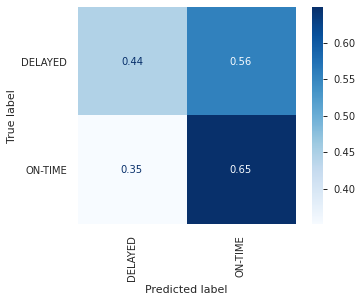

In [ ]:
# Logistic Regression with Under Sampling of the Majority Class
lr_UndSamp = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    StandardScaler(),
    LogisticRegression(multi_class='auto', solver='lbfgs', n_jobs=1))

# Fit on train
lr_UndSamp.fit(X_train_UndSamp, y_train_UndSamp)

# Score on validation
lr_accuracy_score_val_UndSamp = lr_UndSamp.score(X_val, y_val)
print(f'Validation Accuracy : ', lr_accuracy_score_val_UndSamp)

y_pred = lr.predict(X_val)

plot_confusion_matrix(lr_UndSamp, X_val, y_val, values_format='.2f',
                      cmap='Blues', xticks_rotation='vertical', normalize='true')

y_pred_proba = lr_UndSamp.predict_proba(X_val)[:, -1]

lr_roc_auc_score_UndSamp = roc_auc_score(y_val, y_pred_proba)
print(f'ROC AUC SCORE(VAL) : {lr_roc_auc_score_UndSamp}')

print(classification_report(y_val, y_pred))

Random Forest Classifier - with Under Sampling of Majority Class
========


Validation Accuracy :  0.6454007095681823
      Test Accuracy :  0.5175376811161444
ROC AUC SCORE(TEST) : 0.5793601883458042


              precision    recall  f1-score   support

     DELAYED       0.17      0.62      0.27     82182
     ON-TIME       0.89      0.50      0.64    487135

    accuracy                           0.52    569317
   macro avg       0.53      0.56      0.46    569317
weighted avg       0.78      0.52      0.59    569317

CPU times: user 4min 3s, sys: 752 ms, total: 4min 3s
Wall time: 2min 25s


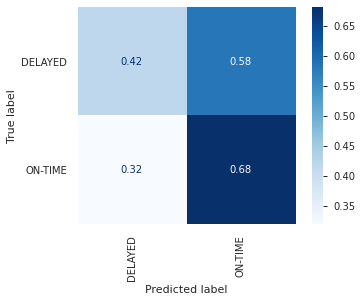

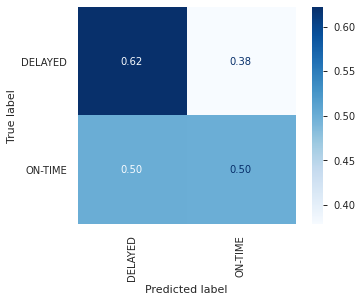

In [ ]:
%%time
# RandomForestClassifier with Under Sampling of the Majority Class
rfc_UndSamp = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='mean'), 
    RandomForestClassifier(n_estimators=115, random_state=42, max_depth=15, 
                           min_samples_leaf=2 , n_jobs=-1))

# Fit on train
rfc_UndSamp.fit(X_train_UndSamp, y_train_UndSamp)

# Score on validation
rfc_accuracy_score_val_UndSamp = rfc_UndSamp.score(X_val, y_val)
print('Validation Accuracy : ', rfc_accuracy_score_val_UndSamp)
rfc_accuracy_score_test_UndSamp = rfc_UndSamp.score(X_test, y_test)
print('      Test Accuracy : ', rfc_accuracy_score_test_UndSamp)

# Predict on test
y_pred = rfc_UndSamp.predict(X_test)

plot_confusion_matrix(rfc_UndSamp, X_val, y_val, values_format='.2f',
                      cmap='Blues', xticks_rotation='vertical',
                      normalize='true')
plot_confusion_matrix(rfc_UndSamp, X_test, y_test, values_format='.2f',
                      cmap='Blues', xticks_rotation='vertical',
                      normalize='true');

y_pred_proba = rfc_UndSamp.predict_proba(X_test)[:, -1] # Probability for last class
rfc_UndSamp_roc_auc_score = roc_auc_score(y_test, y_pred_proba)
print(f'ROC AUC SCORE(TEST) : {rfc_UndSamp_roc_auc_score}\n\n')

print(classification_report(y_test, y_pred))

Comparing Accuracy Score for Various Models
=======


In [ ]:
print(f' Model                                 |  Accuracy Score(val) |   ROC AUC Score(val)   ')
print('='*85)
print(f' Baseline                              |       {baseline_accuracy_score:,.3f}          |           0.500')
print(f' LogisticRegression                    |       {lr_accuracy_score_val:,.3f}          |           {lr_roc_auc_score:,.3f}')
print(f' RandomForestClassifier                |       {rfc_accuracy_score_val:,.3f}          |           {rfc_roc_auc_score:,.3f}')
print('='*85)
print(f' Baseline-UnderSampling                |       {baseline_accuracy_score_UndSamp:,.3f}          |           0.500')
print(f' LogisticRegression-UnderSampling      |       {lr_accuracy_score_val_UndSamp:,.3f}          |           {lr_roc_auc_score:,.3f}')
print(f' RandomForestClassifier -UnderSampling |       {rfc_accuracy_score_val_UndSamp:,.3f}          |           {rfc_UndSamp_roc_auc_score:,.3f}')


 Model                                 |  Accuracy Score(val) |   ROC AUC Score(val)   
 Baseline                              |       0.806          |           0.500
 LogisticRegression                    |       0.864          |           0.573
 RandomForestClassifier                |       0.857          |           0.591
 Baseline-UnderSampling                |       0.500          |           0.500
 LogisticRegression-UnderSampling      |       0.621          |           0.573
 RandomForestClassifier -UnderSampling |       0.645          |           0.579


Confusion Matrix used to compare Machine Learning Models
https://www.youtube.com/watch?v=Kdsp6soqA7o&t=281s

## Comparing the two Random Forest Classifier Models
**Each Confusion Matrix has been normalized = 'true'**

The “normalized” term means that each of these groupings is represented as having 1.00 samples. Thus, the sum of each row in a balanced and normalized confusion matrix is 1.00, because each row sum represents 100% of the elements in a particular topic, cluster, or class.

**Before Undersampling the Majority Class**
- True Positives 0.02
- True Negatives 0.99

This model predicts 
2% of DELAYED 
99% of ON-TIME 

**After Under Sampling the Majority Class**
- True Positives 0.42
- True Negatives 0.68

This model predicts 
42% of DELAYED 
68% of ON-TIME 

Conclusion of the two models the one WITH Undersampling showed better results
I will dive deeper find 
feature importances
permutation importances
PDP plots
and 2 PDP plots

**I will continue with the Random Forest Classifier with Under Sampling for the rest of the project**

Model                |  accuracy score | ROC AUC Score  | precision  | recall      |
---------------------|--------------|-----------|-------|------------|
 | | | |
Before Under Sampling|              |           |       |            |
Baseline | 80.6 | | |
Logistic Regression  |   86.4       |   0.573   | 0.00  |  0.00      |
Random Forest Classifier| 85.7      | 0.591     | 0.22  | 0.02       |
   | | | |
After Under Sampling |              |           |       |            |
Baseline | 50.0 | | |
Logistic Regression  |   62.1       |   0.573   | 0.00  |  0.00      |
Random Forest Classifier| 64.5      | 0.579     | 0.17  | 0.62       |

More about Random Forest Classifier with Undersampling of the Majority Class
=======


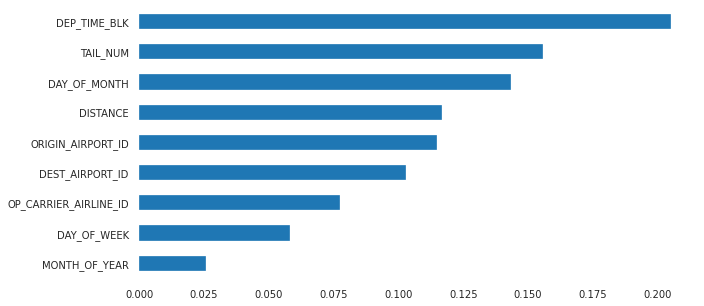

In [ ]:
 # RandomForestClassifier
encoder = rfc_UndSamp.named_steps['ordinalencoder']
encoded_columns = encoder.transform(X_test).columns
rf = rfc_UndSamp.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, encoded_columns)

# Plot top n feature importances
n=20
plt.figure(figsize=(10,n/4))
importances.sort_values()[-n:].plot.barh();

Random Forest Classifier - Permutation Importances
=========


In [ ]:
# Random Forest Classifier - Permutation Importances 1/4
transformers = make_pipeline(
      ce.OrdinalEncoder(),
      SimpleImputer(strategy='mean'))

X_train_transformed = transformers.fit_transform(X_train_UndSamp)
X_val_transformed = transformers.transform(X_val)

model  = RandomForestClassifier(n_estimators=115, 
                           random_state=42, 
                           max_depth=15, min_samples_leaf=2, 
                           n_jobs=-1)
model.fit(X_train_transformed, y_train_UndSamp)

# Random Forest Classifier - Permutation Importances 2/4
permuter = PermutationImportance(
    model,
    scoring = 'accuracy',
    n_iter=5, # Run each permutation 5 times and take the average
    random_state=42) # Seed for reproducibility and tune our model

permuter.fit(X_val_transformed, y_val)

# Random Forest Classifier - Permutation Importances 3/4
feature_names = X_val.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values(ascending=False)

# Random Forest Classifier - Permutation Importances 4/4
eli5.show_weights(permuter, top=None, feature_names=feature_names)

Weight,Feature
0.0186 ± 0.0007,DEP_TIME_BLK
0.0038 ± 0.0006,ORIGIN_AIRPORT_ID
0.0036 ± 0.0003,DISTANCE
0.0028 ± 0.0003,DEST_AIRPORT_ID
0.0026 ± 0.0005,DAY_OF_WEEK
0.0001 ± 0.0007,OP_CARRIER_AIRLINE_ID
0 ± 0.0000,MONTH_OF_YEAR
-0.0010 ± 0.0009,DAY_OF_MONTH
-0.0031 ± 0.0003,TAIL_NUM


From the the Permutation Importance we can see that the 

'DEP_TIME_BLK' the Time of Day is a major factor when predicting FLIGHT STATUS

PDP
======


In [ ]:
# Use Ordinal Encoder, outside of a pipeline
X = train_UndSamp[features]
y = train_UndSamp[target]

encoder = ce.OrdinalEncoder()
X_encoded = encoder.fit_transform(X)
model =  XGBClassifier(n_estimators=115, 
                           random_state=42, 
                           max_depth=15, min_samples_leaf=2, 
                           n_jobs=-1)
model.fit(X_encoded, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=15,
              min_child_weight=1, min_samples_leaf=2, missing=None,
              n_estimators=115, n_jobs=-1, nthread=None,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
              subsample=1, verbosity=1)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


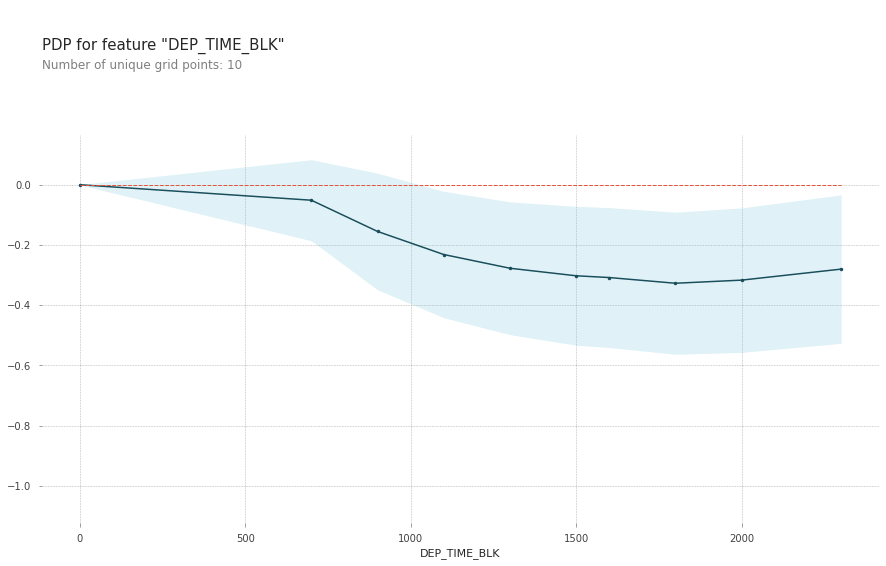

In [ ]:
feature = 'DEP_TIME_BLK'
pdp_dist = pdp.pdp_isolate(model=model, dataset=X_encoded, model_features=features, feature=feature)
pdp.pdp_plot(pdp_dist, feature);

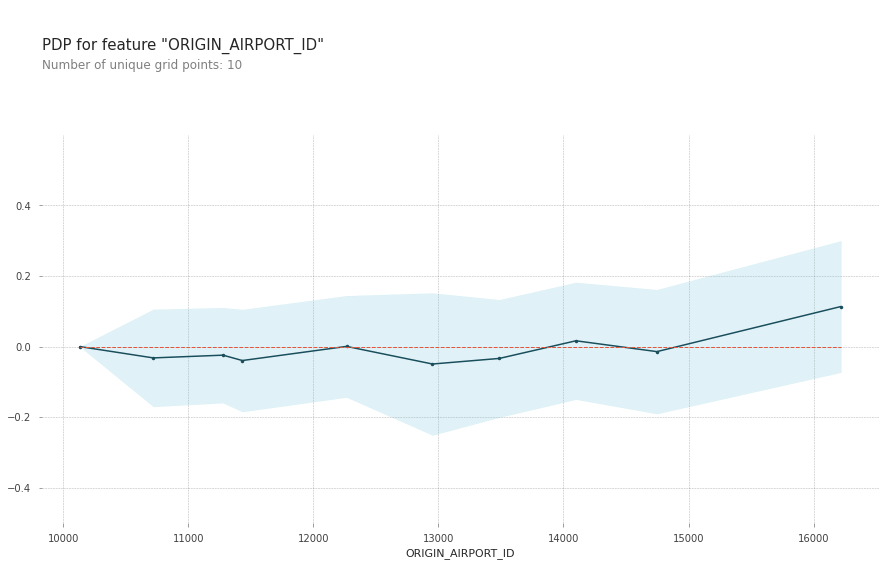

In [ ]:
feature = 'ORIGIN_AIRPORT_ID'
pdp_dist = pdp.pdp_isolate(model=model, dataset=X_encoded, model_features=features, feature=feature)
pdp.pdp_plot(pdp_dist, feature);

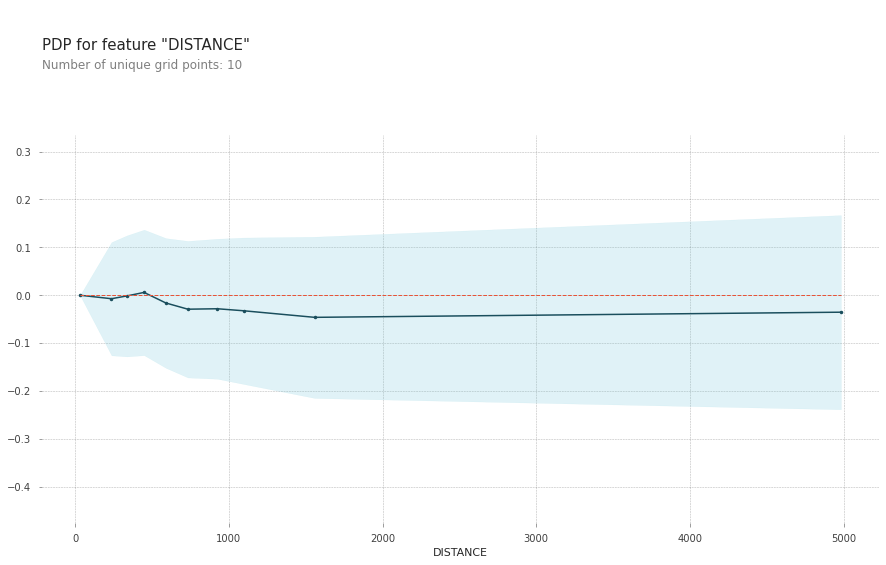

In [ ]:
feature = 'DISTANCE'
pdp_dist = pdp.pdp_isolate(model=model, dataset=X_encoded, model_features=features, feature=feature)
pdp.pdp_plot(pdp_dist, feature);

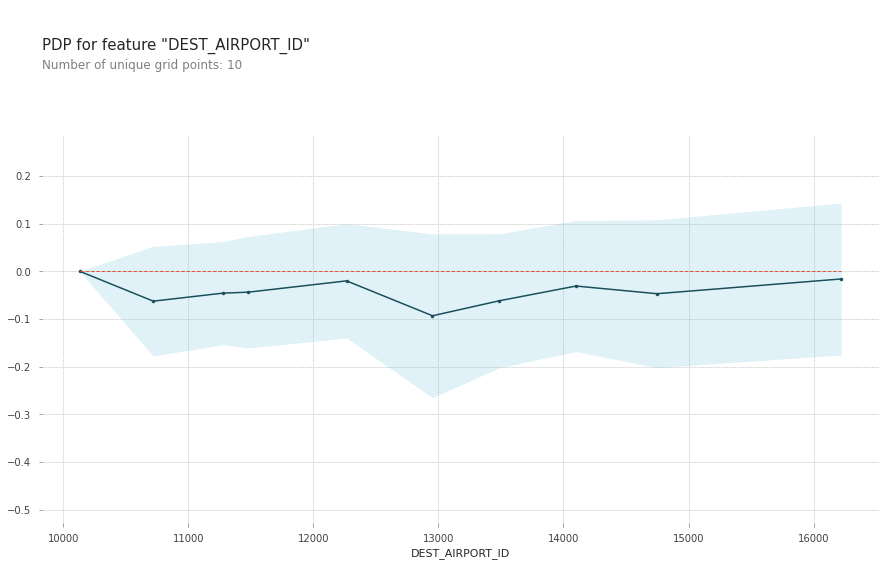

In [ ]:
feature = 'DEST_AIRPORT_ID'
pdp_dist = pdp.pdp_isolate(model=model, dataset=X_encoded, model_features=features, feature=feature)
pdp.pdp_plot(pdp_dist, feature);

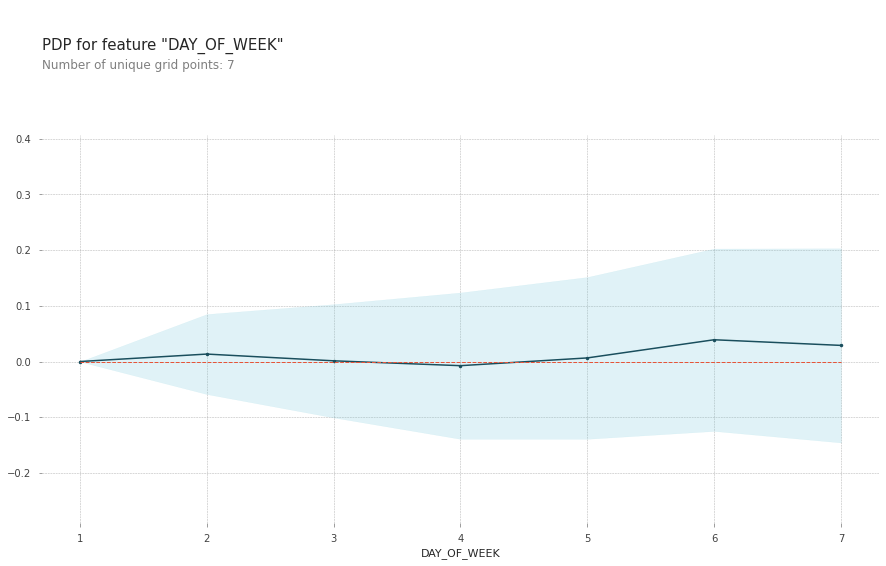

In [ ]:
feature = 'DAY_OF_WEEK'
pdp_dist = pdp.pdp_isolate(model=model, dataset=X_encoded, model_features=features, feature=feature)
pdp.pdp_plot(pdp_dist, feature);

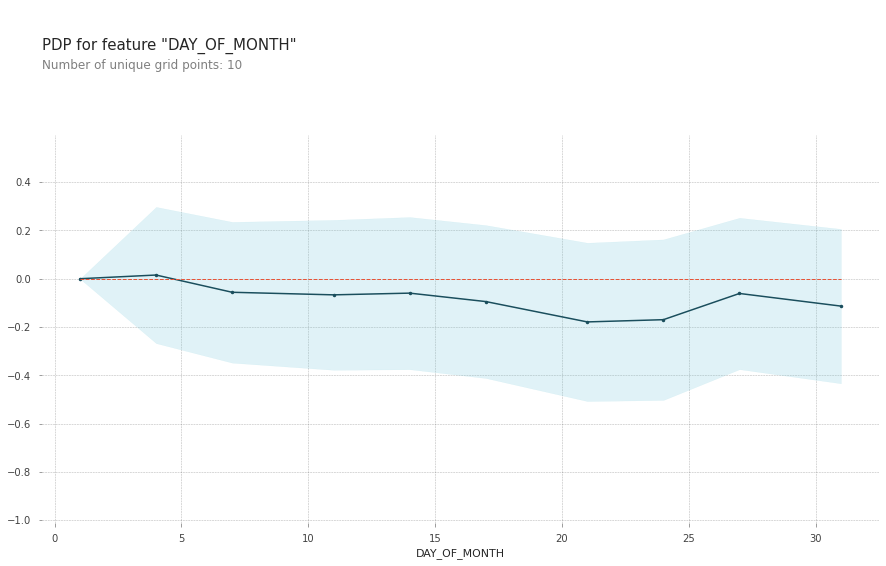

In [ ]:
feature = 'DAY_OF_MONTH'
pdp_dist = pdp.pdp_isolate(model=model, dataset=X_encoded, model_features=features, feature=feature)
pdp.pdp_plot(pdp_dist, feature);

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


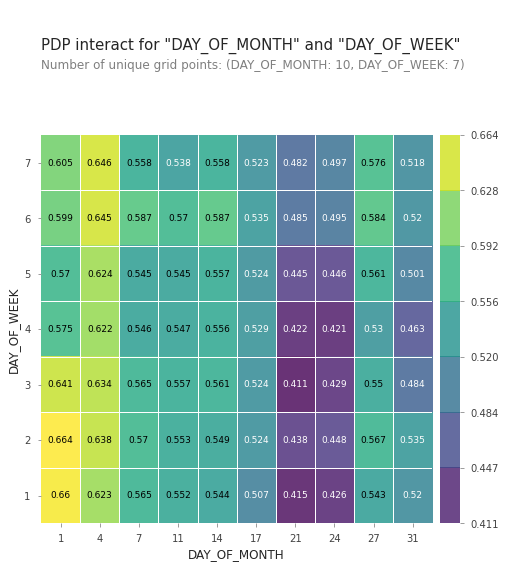

In [ ]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

features = ['DAY_OF_MONTH', 'DAY_OF_WEEK']

interaction = pdp_interact(
    model=model, 
    dataset=X_encoded, 
    model_features=X_encoded.columns, 
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);

Exploration into data leakage
======


['DAY_OF_MONTH', 'DAY_OF_WEEK', 'OP_CARRIER_AIRLINE_ID', 'ORIGIN_AIRPORT_ID', 'DEST_AIRPORT_ID', 'DEP_TIME', 'DEP_TIME_BLK', 'ARR_TIME', 'ARR_DEL15', 'CANCELLED', 'DIVERTED', 'DISTANCE', 'MONTH_OF_YEAR']
13
Validation Accuracy : 0.943
      Test Accuracy : 0.942
 ROC AUC SCORE(val) : 0.937
              precision    recall  f1-score   support

     DELAYED       0.83      0.73      0.78     81884
     ON-TIME       0.96      0.98      0.97    518763

    accuracy                           0.94    600647
   macro avg       0.89      0.85      0.87    600647
weighted avg       0.94      0.94      0.94    600647

CPU times: user 7min 56s, sys: 1.04 s, total: 7min 57s
Wall time: 4min 22s


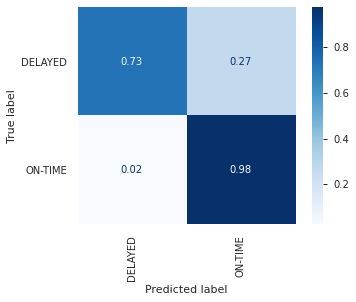

In [ ]:
%%time
# This section deals with the high cardinality

# The status_group column is the target
target='DEP_DEL15'

# Get a dataframe with all train columns except the target
train_features_DL = train_DL.drop(columns=[target])

# Get a list of the numeric features
numeric_features_DL = train_features_DL.select_dtypes(include='number').columns.tolist()

# Get a series with the cardinality of the nonnumeric features
cardinality_DL = train_features_DL.select_dtypes(exclude='number').nunique()

# Get a list of all categorical features with cardinality 
#<= 5550 == the number of different airplanes
categorical_features_DL = cardinality_DL[cardinality_DL <= 5550].index.tolist()

# Combine the lists 
features_DL = numeric_features_DL + categorical_features_DL
print(features_DL)
print(len(features_DL))
# Data Leakage Experiement
#Arrange data into X features matrix and y target vector
X_train_DL = train_DL[features_DL]
y_train_DL = train_DL[target]
X_val_DL = val_DL[features_DL]
y_val_DL = val_DL[target]
X_test_DL = test_DL[features_DL]
y_test_DL = test_DL[target]
# RandomForestClassifier
rfc = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='mean'), 
    RandomForestClassifier(n_estimators=115, random_state=42, max_depth=15, 
                           min_samples_leaf=2, n_jobs=-1))

# Fit on train
rfc.fit(X_train_DL, y_train_DL)

# Score on validation
rfc_accuracy_score_val_DL = rfc.score(X_val_DL, y_val_DL)
print(f'Validation Accuracy : {rfc_accuracy_score_val_DL:.3f}')
rfc_accuracy_score_test_DL = rfc.score(X_test_DL, y_test_DL)
print(f'      Test Accuracy : {rfc_accuracy_score_test_DL:.3f}')

y_pred = rfc.predict(X_val_DL)

plot_confusion_matrix(rfc, X_val_DL, y_val_DL, values_format='.2f',
                      cmap='Blues', xticks_rotation='vertical', normalize='true')

y_pred_proba = rfc.predict_proba(X_val_DL)[:, -1] 

rfc_roc_auc_score_DL = roc_auc_score(y_val_DL, y_pred_proba)
print(f' ROC AUC SCORE(val) : {rfc_roc_auc_score_DL:.3f}')

print(classification_report(y_val_DL, y_pred))

This would be an awesome model but again this contains future data AKA Data Leakage

Check All Point Covered
=======

https://lambdaschool.github.io/ds/unit2/portfolio-project/dspt6